# Purpose

This notebook is to test whether the `neuro_op` module's nodes can successfully infer `world_dist` if only this distribution's information pieces $x_{world}$ are received (i.e., with rates h>0, r=0).

For this, the model is run with nodes receiving different amount of information (i.e., different `t_max`, `h`). Then, each node's posterior predictive distribution (*PPD*), equalling its forecast of future incoming information, is obtained via 
1. sampling of model parameters $\theta$ proportional to its posterior $p(\theta | x_{world})$;
2. using these sampled model parameters to generate data proportional to the model likelihood $p(x_{PPD}|\theta_{sampled})$

PPDs thereby fully conserves uncertainty by paying respect to both posterior and likelihood stochasticity.

We then use the PPDs to quantify the nodes' modelling accuracy by computing the Kullback-Leibler divergence and average MLE distances between node PPDs and data generated by `world_dist`.

In [8]:
import neuro_op as nop
import matplotlib.pyplot as plt

import networkx as nx
import numpy as np
import scipy.stats as st

In [127]:
def build_stochastic_block_model(N_nodes, N_blocks, N_neighbours, p_in=0.5, p_out=0.1):
    """
    Build and return a directed stochastic block model graph.

    Build a graph of N_blocks equally-sized blocks with p_in probability of connection within a block and p_out probability of connection between blocks.
    """
    
    block_sizes = [N_nodes // N_blocks] * N_blocks
    block_sizes[-1] += N_nodes % N_blocks  # add remainder to last block
    p = []
    for i in range(N_blocks):
        p += [[p_out] * N_blocks]
        p[i][i] = p_in
    
    p = np.array(p)/np.sum(p)
    G_tmp = nx.stochastic_block_model(block_sizes, p, directed=True)
    mean_degree = np.sum([G_tmp.degree(n) for n in G_tmp.nodes()]) / (2*len(G_tmp))
    p = p * N_neighbours / mean_degree
    G = nx.stochastic_block_model(block_sizes, p, directed=True)
    # Small plausibility checks
    assert len(G) == N_nodes
    print("Mean degree: ", np.sum([G.degree(n) for n in G.nodes()]) / (2*len(G)))

    return G


G = build_stochastic_block_model(100, 3, 20)

subax = plt.subplot(111)
nx.draw_spring(G, ax=subax, node_size=40)

NetworkXException: 'sizes' and 'p' do not match.

In [2]:
def p0(x):
    return st.powerlaw(a=0.5, scale=50).logpdf(x=np.abs(x))

# Reference input for 'run_model' function. For description of contents, see 'run_model' function docstring.
input = dict(
    laplace=False,
    N_nodes=100,
    N_neighbours=11,  # JZ: powers of 12 ~ typcial group sizes
    N_beliefs=500,
    belief_range=(-50, 50),
    log_priors=np.zeros(500),
    llh=st.norm(loc=0, scale=5),
    world_llh=st.norm(loc=0, scale=5),
    h=1,
    r=1,
    t0=0,
    t_max=100,
    t_sample=2,
    sample_bins=50,
    sample_range=(-20, 20),
    p_distance_params=[(1, 1), (2, 1)],
    progress=False,
)

In [3]:
out1 = nop.run_model(**input)

print(f"Number of events: {out1['N_events']}")

TypeError: 'rv_continuous_frozen' object is not callable

## Data analysis

Random data analysis test notebook of steps later used in thorough analysis.


In [ ]:
# For improving of readability, increase all font sizes of plots. Also, set legend location to upper right.
plt.rcParams.update(
    {
        "font.size": 20,
        "legend.loc": "upper right",
    }
)

#### Data analysis 1

Firstly, extract output values for further analysis:

In [ ]:
for i in out1.keys():
    print(i)

nodes
G
beliefs
world
N_events
t_end
mu_nodes
kl_divs
p_distances
seed



Each node's posteriors are plotted. One should see nodes' posteriors of model parameters (in this case, $\mu$), to converge around the true value. If not, nodes may need more information to converge ($\rightarrow$ increase $t_{max}, h$).


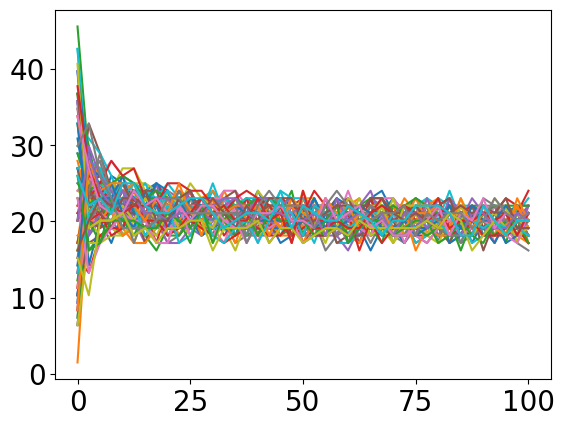

In [ ]:
mu_arr = np.array(out1["mu_nodes"])
x = np.arange(input["t0"], input["t_max"] + input["t_sample"], input["t_sample"])
for i in range(len(mu_arr.T)):
    plt.plot(x, mu_arr.T[i])

#### Data analysis 2

In [ ]:
kld = np.array(out1["kl_divs"])
lin_dis = np.array(out1["p_distances"])[:, 0]
lin_dis.shape

(41, 2, 100)

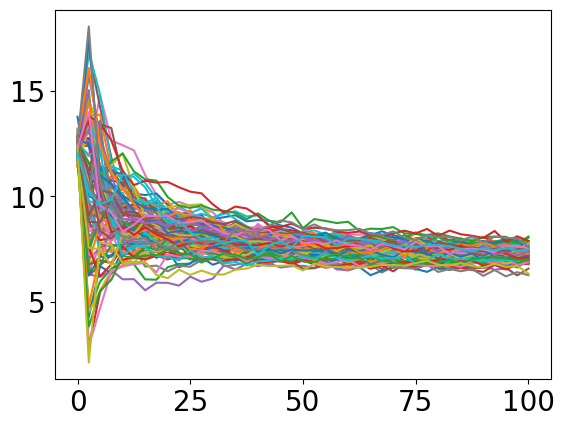

In [ ]:
for i in range(input["N_nodes"]):
    plt.plot(input["t_sample"] * np.arange(0, kld.shape[0]), kld[:, i, 1])

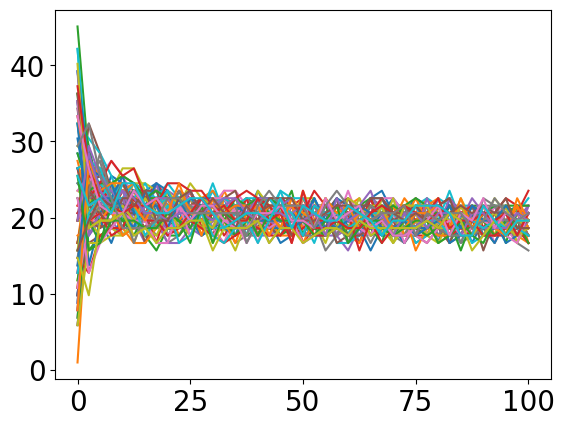

In [ ]:
for i in range(input["N_nodes"]):
    plt.plot(input["t_sample"] * np.arange(0, lin_dis.shape[0]), lin_dis[:, 1, i])

In [ ]:
arr = np.array(out1["p_distances"])
arr.shape
(arr[-1, 0, 1, :] ** 2).mean()

379.20991926182234

In [ ]:
arr2 = np.array(out1["kl_divs"])
arr2.shape

(41, 100, 2)

In [ ]:
np.array(out1["mu_nodes"]).shape

(41, 100)